<a href="https://colab.research.google.com/github/BenyaminZojaji/Deep_Learning/blob/main/sheikhDetector/sheikhDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

### Import libraries

In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import wandb
from wandb.keras import WandbCallback

### Wandb configuration

In [33]:
wandb.init(project="sheykhDetector", entity="benyaminzojaji")

wandb: Currently logged in as: benyaminzojaji (use `wandb login --relogin` to force relogin)


In [34]:
config = wandb.config
config.learning_rate = 0.001

### Dataset

In [2]:
train_dataset_path = '/content/drive/MyDrive/Dataset/Sheykh-Recognition'
width = height = 224
batch_size = 32

idg = ImageDataGenerator(
    rescale = 1./255,

    # Augmentation
    horizontal_flip = True,
    zoom_range = 0.1,
    rotation_range = 10,
    brightness_range = (0.8, 1.2),
    validation_split = 0.2
)

train_data = idg.flow_from_directory(
    train_dataset_path,
    target_size=(width, height),
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)

val_data = idg.flow_from_directory(
    train_dataset_path,
    target_size=(width, height),
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation'
)

Found 212 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


### Visualization

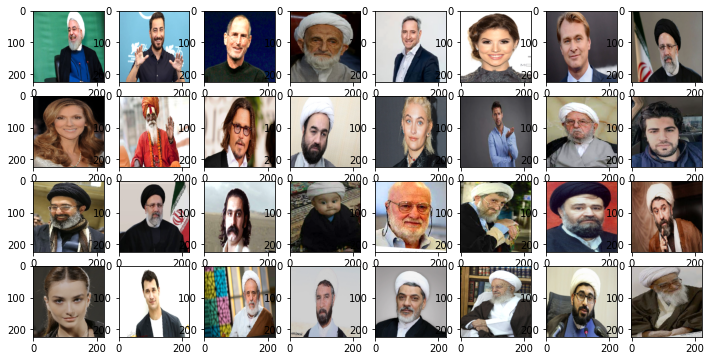

In [8]:
some_images = next(train_data)
X=some_images[0]
Y=some_images[1]

plt.figure(figsize=(12,6))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(X[i])

### Model

In [35]:
base_model = tf.keras.applications.VGG16(
    weights="imagenet",
    input_shape=(width,height,3),
    include_top=False,
    pooling='avg')

In [36]:
base_model.trainable = False

In [37]:
model = tf.keras.models.Sequential([
    base_model,
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation="softmax")
])

In [ ]:
model.summary()

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [39]:
model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[WandbCallback()])

Epoch 1/10
7/7 [==============================] - 13s 2s/step - loss: 0.7565 - accuracy: 0.4858 - val_loss: 0.6799 - val_accuracy: 0.5000 - _timestamp: 1647423005.0000 - _runtime: 74.0000
Epoch 2/10
7/7 [==============================] - 12s 2s/step - loss: 0.6654 - accuracy: 0.6038 - val_loss: 0.6152 - val_accuracy: 0.8269 - _timestamp: 1647423017.0000 - _runtime: 86.0000
Epoch 3/10
7/7 [==============================] - 11s 1s/step - loss: 0.6001 - accuracy: 0.7736 - val_loss: 0.5263 - val_accuracy: 0.9231 - _timestamp: 1647423036.0000 - _runtime: 105.0000
Epoch 4/10
7/7 [==============================] - 11s 2s/step - loss: 0.4913 - accuracy: 0.8868 - val_loss: 0.4042 - val_accuracy: 0.9231 - _timestamp: 1647423048.0000 - _runtime: 117.0000
Epoch 5/10
7/7 [==============================] - 11s 2s/step - loss: 0.3805 - accuracy: 0.9009 - val_loss: 0.2762 - val_accuracy: 0.9423 - _timestamp: 1647423058.0000 - _runtime: 127.0000
Epoch 6/10
7/7 [==============================] - 11s 2s/

In [40]:
model.save('vgg16-sheykhDetector.h5')

In [82]:
test_dataset_path = '/content/drive/MyDrive/Dataset/test'
width = height = 224
batch_size = 32

idg = ImageDataGenerator(
    rescale = 1./255,
)

test_data = idg.flow_from_directory(
    test_dataset_path,
    target_size=(width, height),
    class_mode='categorical',
    batch_size=batch_size,
)

Found 24 images belonging to 2 classes.


In [83]:
model.evaluate(test_data)

1/1 [==============================] - 1s 866ms/step - loss: 0.2865 - accuracy: 0.9583


[0.28649869561195374, 0.9583333134651184]

In [84]:
Y_pred = []

for path in test_data.filepaths:
  try:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (width, height))
    img = img / 255
    img = img.reshape(1, width, height, 3)
    Y_pred.append(np.argmax(model.predict(img)))
  except:
    print(path)#if image isn't readable


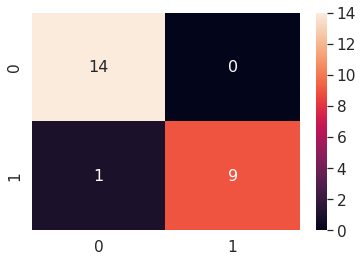

In [85]:
conf_mat = confusion_matrix(test_data.classes, Y_pred)
sn.set(font_scale=1.4) # for label size
sn.heatmap(conf_mat, annot=True, annot_kws={"size": 16})
plt.show()